# Assignemt 3 - Task 3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
scale = 0.2
frames_to_save = [250, 350, 365] # There are 378 frames in the video

## Moving Object Segmentation & Bounding Box

### MOG Segmentation

In [3]:
mog2_sub = cv2.createBackgroundSubtractorMOG2()
video = cv2.VideoCapture("data/motion/crosswalk.avi")

n = 0
frames = []
masks = []
segmented_frames = []

In [4]:
while video.isOpened():
    ret, curr_frame = video.read()
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break
    n += 1
    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)

    fgmask = mog2_sub.apply(curr_frame)
    mask_of_movement = np.where((fgmask == 255), 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask_of_movement, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))

    mask_of_movement = np.zeros_like(mask_of_movement)
    curr_frame_to_segment = curr_frame.copy()
    
    if len(areas):
        largest = contours[np.argmax(areas)]
        mask_of_movement = cv2.fillPoly(mask_of_movement, [largest], 1)
        x, y, w, h = cv2.boundingRect(largest)
        cv2.rectangle(curr_frame, (x, y), (x + w, y + h), (0,255,0), 1)

    segemented = curr_frame_to_segment * cv2.merge([mask_of_movement,mask_of_movement,mask_of_movement])

    cv2.imshow("Frame", curr_frame)
    cv2.imshow("Mask", mask_of_movement * 255)
    cv2.imshow("Segmented", segemented)

    if n in frames_to_save:
        frames.append(curr_frame)
        masks.append(mask_of_movement)
        segmented_frames.append(segemented)

video.release() 
cv2.destroyAllWindows()

In [5]:
print(n)

378


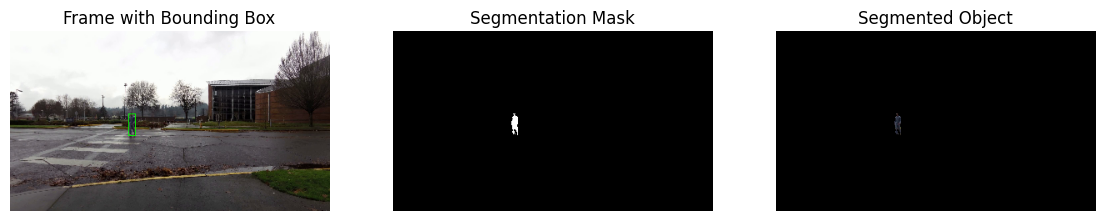

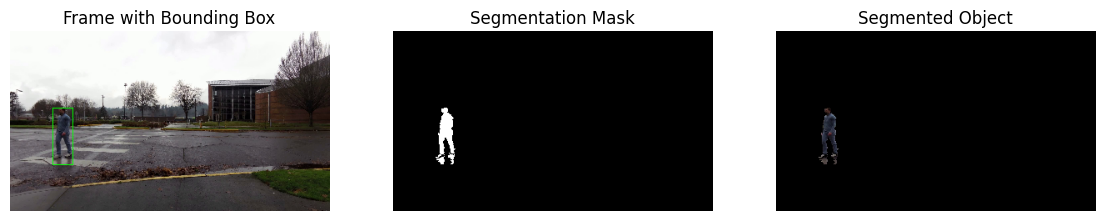

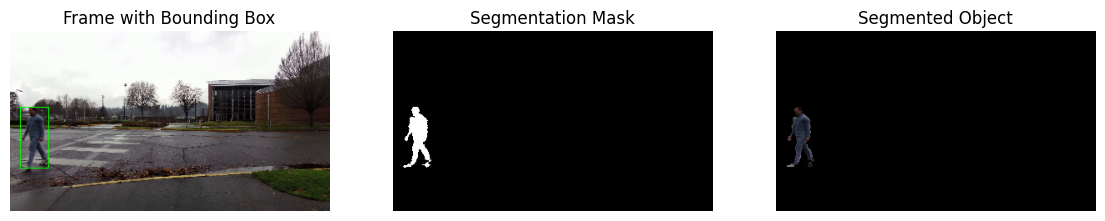

In [6]:
rows = 1
cols = 3

for img1, img2, img3 in zip(frames, masks, segmented_frames):
    fig = plt.figure(figsize=(14,5))

    fig.add_subplot(rows, cols, 1)
    plt.axis("off")
    plt.title("Frame with Bounding Box")
    plt.imshow(img1[:,:,::-1])

    fig.add_subplot(rows, cols, 2)
    plt.axis("off")
    plt.title("Segmentation Mask")
    plt.imshow(img2, cmap="gray")

    fig.add_subplot(rows, cols, 3)
    plt.axis("off")
    plt.title("Segmented Object")
    plt.imshow(img3[:,:,::-1])

### Segmentation using Running Average Background Image

In [7]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

frame1 = cv2.resize(frame1, None, fx=scale, fy=scale)

In [8]:
running_average = np.float32(frame1) # future background model

while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)
    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)

    cv2.accumulateWeighted(curr_frame, running_average, 0.02)
    
running_average = cv2.convertScaleAbs(running_average)

video.release()
cv2.destroyAllWindows()

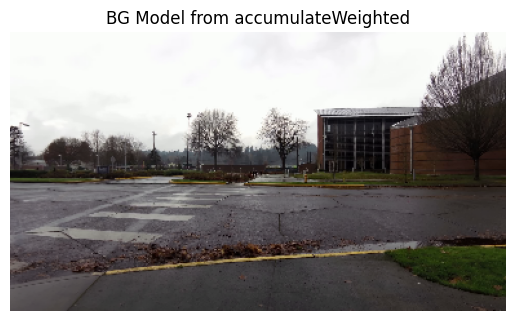

In [9]:
plt.axis("off")
plt.title("BG Model from accumulateWeighted")
plt.imshow(running_average[:,:,::-1])

In [10]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
gray_model = cv2.cvtColor(running_average, cv2.COLOR_BGR2GRAY)

n = 0
frames2 = []
masks2 = []
segmented_frames2 = []

masks_in_one = np.zeros_like(gray_model)

struct_elem_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

In [11]:
while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break
    n += 1

    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)
    gray_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(gray_frame, gray_model)

    mask = np.where(diff > 20, 1, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struct_elem_close)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))

    mask = np.zeros_like(mask)
    curr_frame_to_segment = curr_frame.copy()
    
    if len(areas):
        largest = contours[np.argmax(areas)]
        mask = cv2.fillPoly(mask, [largest], 1)
        x, y, w, h = cv2.boundingRect(largest)
        cv2.rectangle(curr_frame, (x, y), (x + w, y + h), (0,255,0), 1)
        
    segemented = curr_frame_to_segment * cv2.merge([mask,mask,mask])

    cv2.imshow("Frame", curr_frame)
    cv2.imshow("Mask", mask * 255)
    cv2.imshow("Segmented", segemented)
    
    if n in frames_to_save:
        frames2.append(curr_frame)
        masks2.append(mask)
        segmented_frames2.append(segemented)

    masks_in_one |= mask

video.release()
cv2.destroyAllWindows()

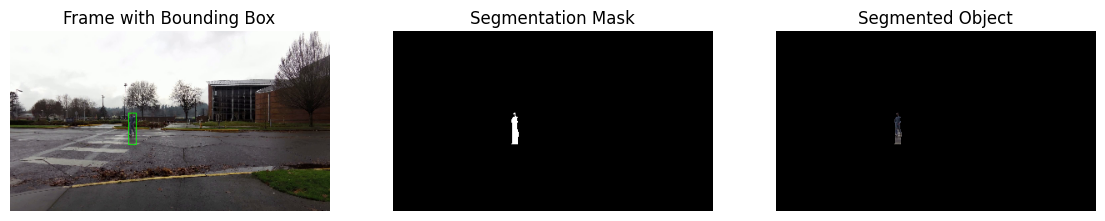

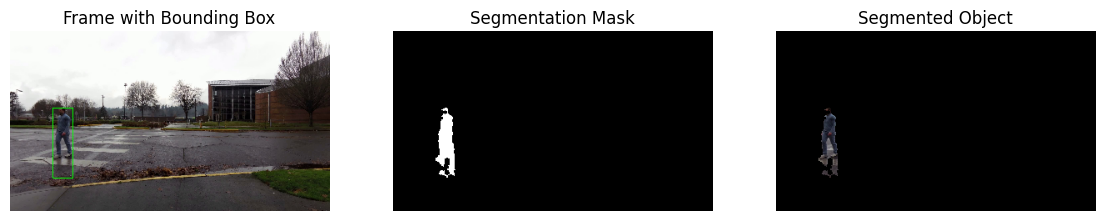

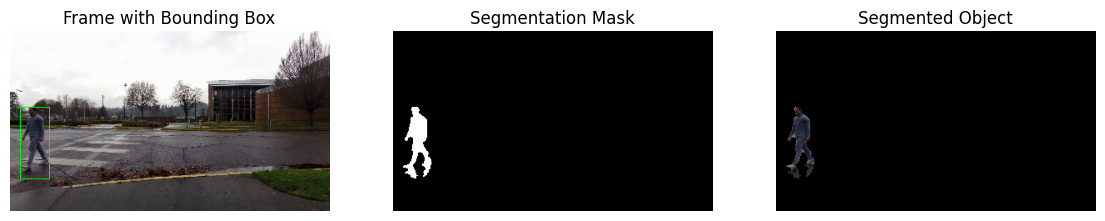

In [12]:
rows = 1
cols = 3

for img1, img2, img3 in zip(frames2, masks2, segmented_frames2):
    fig = plt.figure(figsize=(14,5))

    fig.add_subplot(rows, cols, 1)
    plt.axis("off")
    plt.title("Frame with Bounding Box")
    plt.imshow(img1[:,:,::-1])

    fig.add_subplot(rows, cols, 2)
    plt.axis("off")
    plt.title("Segmentation Mask")
    plt.imshow(img2, cmap="gray")

    fig.add_subplot(rows, cols, 3)
    plt.axis("off")
    plt.title("Segmented Object")
    plt.imshow(img3[:,:,::-1])

## Dense Optical Flow & Bounding Box

In [25]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.resize(prev_gray, None, fx=scale, fy=scale)

flow_image = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), np.uint8)
flow_image[:,:,1] = 255

params = {
    "pyr_scale": 0.5,
    "levels": 1,
    "winsize": 10,
    "iterations": 3,
    "poly_n": 7,
    "poly_sigma": 1.5,
    "flags": 0
}

n = 0
dense_frames = []
frames3 = []
masks3 = []

In [26]:
while video.isOpened():
    ret, curr_frame = video.read()
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break
    n += 1

    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **params)
    magnitude, angle = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])

    flow_image[:,:,0] = angle * 180 / np.pi / 2
    flow_image[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    mask = np.where(flow_image[:,:,2] > 45, 1, 0).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))

    mask = np.zeros_like(mask)
    
    if len(areas):
        largest = contours[np.argmax(areas)]
        mask = cv2.fillPoly(mask, [largest], 1)
        x, y, w, h = cv2.boundingRect(largest)
        cv2.rectangle(curr_frame, (x, y), (x + w, y + h), (0,255,0), 1)
        
    cv2.imshow("Mask", mask*255)
    
    bgr_frame = cv2.cvtColor(flow_image, cv2.COLOR_HSV2BGR)
    cv2.imshow("Flow", bgr_frame)
    cv2.imshow("Frame", curr_frame)
    
    if n in frames_to_save + [10,25,50]:
        frames3.append(curr_frame)
        dense_frames.append(bgr_frame)
        masks3.append(mask)

    prev_gray = curr_gray

video.release() 
cv2.destroyAllWindows()

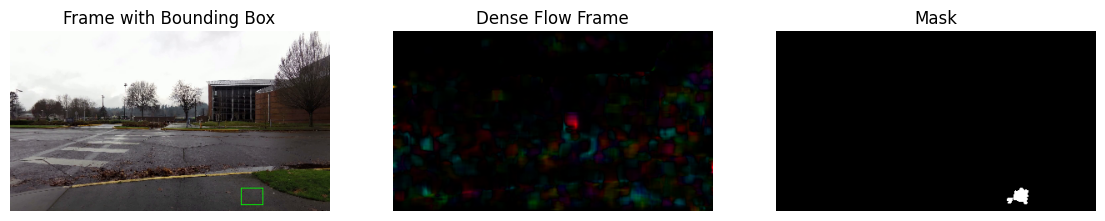

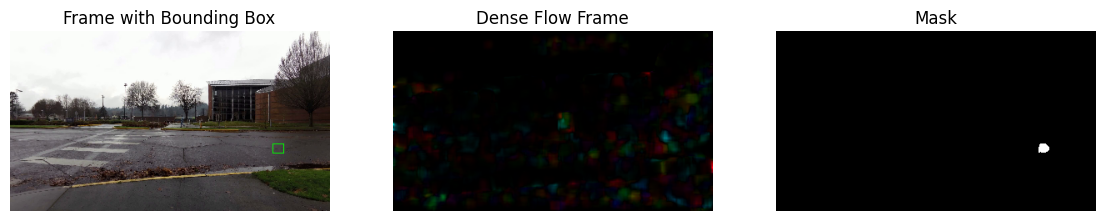

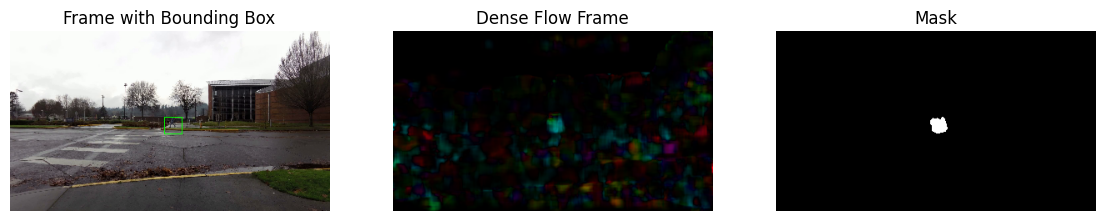

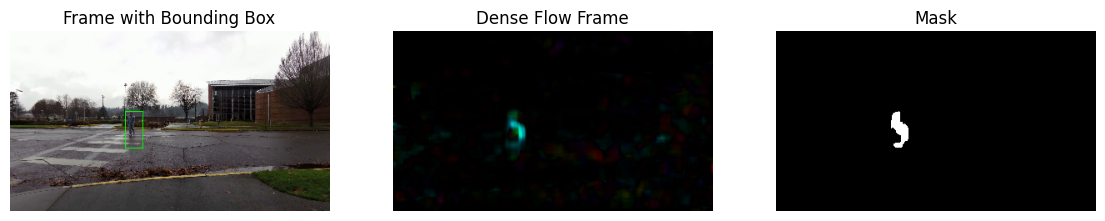

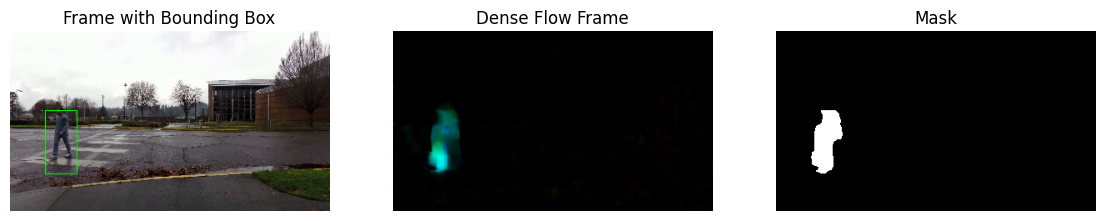

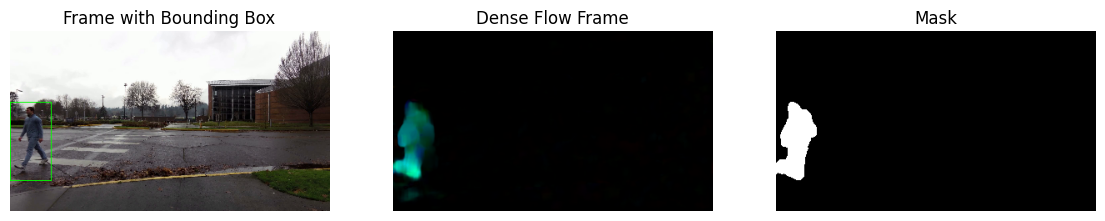

In [29]:
rows = 1
cols = 3

for img1, img2, img3 in zip(frames3, dense_frames, masks3):
    fig = plt.figure(figsize=(14,5))

    fig.add_subplot(rows, cols, 1)
    plt.axis("off")
    plt.title("Frame with Bounding Box")
    plt.imshow(img1[:,:,::-1])

    fig.add_subplot(rows, cols, 2)
    plt.axis("off")
    plt.title("Dense Flow Frame")
    plt.imshow(img2[:,:,::-1])

    fig.add_subplot(rows, cols, 3)
    plt.axis("off")
    plt.title("Mask")
    plt.imshow(img3, cmap="gray")

## Sparse Optical Flow

In [16]:
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
masks_in_one_improved = cv2.morphologyEx(masks_in_one, cv2.MORPH_OPEN, struct_elem)

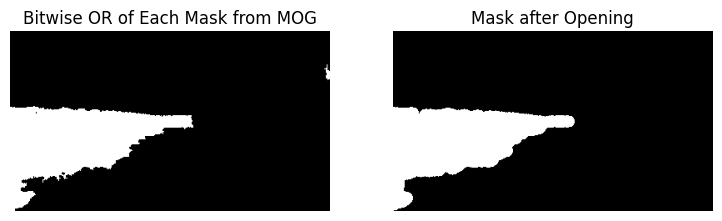

In [17]:
fig = plt.figure(figsize=(14,5))
rows = 1
cols = 3

fig.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title("Bitwise OR of Each Mask from MOG")
plt.imshow(masks_in_one, cmap="gray")

fig.add_subplot(rows, cols, 2)
plt.axis("off")
plt.title("Mask after Opening")
plt.imshow(masks_in_one_improved, cmap="gray")

In [21]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

feature_params = {
    "mask": masks_in_one_improved,
    "maxCorners": 25,
    "qualityLevel": 0.15,
    "minDistance": 7,
    "blockSize": 7
}

sparse_frames = []

prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.resize(prev_gray, None, fx=scale, fy=scale)

mask = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), np.uint8)
p_prev = cv2.goodFeaturesToTrack(prev_gray, **feature_params)

n = 0

In [22]:
colors = np.random.randint(0, 255, (100, 3))

while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break
    n += 1

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)
    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)
    
    p_curr, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, p_prev, None)

    if p_curr is not None:
        p_prev = p_prev[status == 1]
        p_curr = p_curr[status == 1]

    for i, (prev, curr) in enumerate(zip(p_prev, p_curr)):
        a, b = curr.ravel()
        c, d = prev.ravel()

        mask = cv2.line(mask, (int(a),int(b)), (int(c),int(d)), colors[i].tolist(), 2)
        curr_frame = cv2.circle(curr_frame, (int(a),int(b)), 4, colors[i].tolist(), -1)
        curr_frame = cv2.bitwise_or(curr_frame, mask)

    cv2.imshow("Frame", curr_frame)

    if n in frames_to_save:
        sparse_frames.append(curr_frame)
        
    p_prev = p_curr.reshape(-1, 1, 2)
    prev_gray = curr_gray

video.release()
cv2.destroyAllWindows()

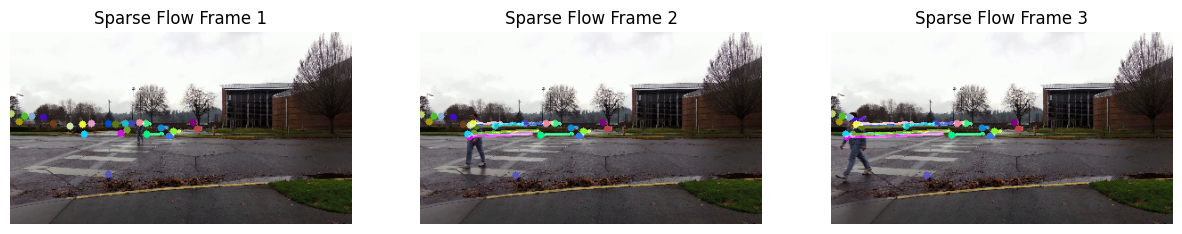

In [23]:
rows = 1
cols = 3

fig = plt.figure(figsize=(15,6))

for i, img in enumerate(sparse_frames):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.title(f"Sparse Flow Frame {i+1}")
    plt.imshow(img[:,:,::-1])